In [7]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Set the font family and size for LaTeX rendering
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 18

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
# create a compiled results.csv file. Each row corresponds to one model fit in stan. There should be three columns containing the following:
# 1. stan_sample_file: path to file where stan samples are saved
# 2. model_type: what type of model was fit (options: ['no_additional_constraints', 'prevalence', 'expertise'])
# 3. data_file: path to the data the model was fit on (this data file should contain the true parameter values)

results = pd.read_csv('results.csv')

In [3]:
# get all simulated data 
# this is done separately to reduce the number of times we need to unpickle since data files are shared
simulated_datas = {}
for file_name in set(results['data_file']):
    file = open(file_name, 'rb')
    simulated_datas[file_name] = pickle.load(file)
    file.close()

In [4]:
# model parameters
M = 5 # num features (including intercept)
not_sparse_indices = [0, 1] # feature indices which are not sparse
num_datasets = len(simulated_datas)

parameters_to_plot = ['beta_Y', 'beta_delta', 'sigma_Z']
parameters_names = [r'$\beta_Y$', r'$\beta_\Delta$', r'$\sigma$']
model_types_to_plot = ['expertise', 'prevalence']
reference_model_type = 'no_additional_constraints'
labels = ['expertise constraint', 'prevalence constraint']

In [5]:
# get all accuracy and precision metrics
cis = {}
abserrs = {}
for j in range(len(results)):
    file = results.iloc[j]['stan_sample_file']
    df = pd.read_csv(file)
    simulated_data = simulated_datas[results.iloc[j]['data_file']]
    
    # get beta_Y data
    for i in range(M):
        param = 'beta_Y.{}'.format(i+1)
        if param not in cis:
            cis[param] = []
            abserrs[param] = []
        cis[param].append(df[param].quantile(0.975) - df[param].quantile(0.025))
        abserrs[param].append(np.abs(df[param].mean() - simulated_data['parameters']['beta_Y'][i]))
        
    # get beta_delta data
    for i in not_sparse_indices:
        param = 'beta_delta.{}'.format(i+1)
        if param not in cis:
            cis[param] = []
            abserrs[param] = []
        cis[param].append(df['masked_beta_delta.{}'.format(i+1)].quantile(0.975) - df['masked_beta_delta.{}'.format(i+1)].quantile(0.025))
        abserrs[param].append(np.abs(df['masked_beta_delta.{}'.format(i+1)].mean() - simulated_data['parameters']['beta_delta'][i]))
        
    # get sigma data
    param = 'sigma_Z'
    if param not in cis:
        cis[param] = []
        abserrs[param] = []
    cis[param].append(df[param].quantile(0.975) - df[param].quantile(0.025))
    abserrs[param].append(np.abs(df[param].mean() - simulated_data['parameters'][param]))
    
for key in cis:
    results['{}_95%_ci_width'.format(key)] = cis[key]
    results['{}_abserr'.format(key)] = abserrs[key]

/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_2804974/209010893.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{}%'.format(int(x)) for x in vals])
/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_2804974/209010893.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{}%'.format(int(x)) for x in vals])


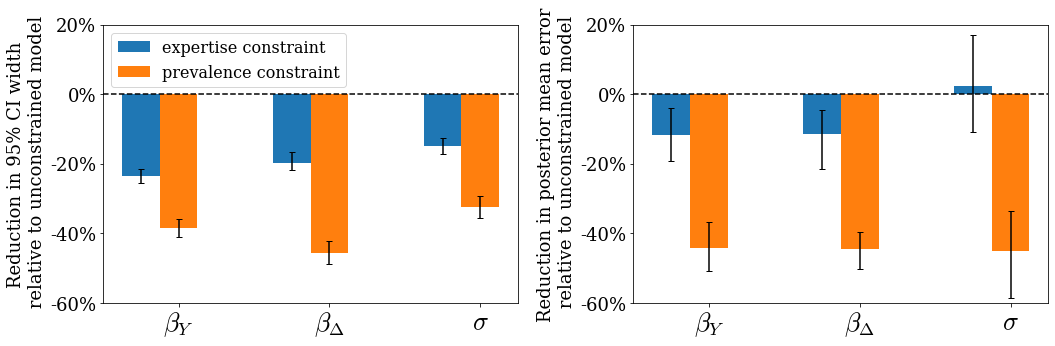

In [10]:
# make plot
x = np.arange(len(parameters_to_plot))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, model_type in enumerate(model_types_to_plot):
    # plot accuracy
    medians = []
    ci95_lens = []
    for param in parameters_to_plot:
        cols = [c for c in results.columns if (param in c) & ('abserr' in c)]
        constrained = results[results['model_type'] == model_type][cols].mean(axis=1).to_numpy()
        unconstrained = results[results['model_type'] == reference_model_type][cols].mean(axis=1).to_numpy()
        percent_change = (constrained - unconstrained) / unconstrained * 100
        
        # bar plots median value
        medians.append(np.median(percent_change))
        
        # bootstrap CI
        sampled_medians = []
        for _ in range(1000):
            sampled_percent_change = np.random.choice(percent_change, size=len(percent_change))
            sampled_medians.append(np.median(sampled_percent_change))
        sampled_medians = np.array(sampled_medians)
        ci95_lens.append([sampled_medians.mean() - np.quantile(sampled_medians, 0.025), np.quantile(sampled_medians, 0.975) - sampled_medians.mean()])
        
    offset = width * multiplier
    rects = axs[1].bar(x + offset, medians, width, yerr=np.array(ci95_lens).transpose(), label=labels[i], capsize=3)
    
    # plot precision
    medians = []
    ci95_lens = []
    for param in parameters_to_plot:
        cols = [c for c in results.columns if (param in c) & ('ci_width' in c)]
        constrained = results[results['model_type'] == model_type][cols].mean(axis=1).to_numpy()
        unconstrained = results[results['model_type'] == reference_model_type][cols].mean(axis=1).to_numpy()
        percent_change = (constrained - unconstrained) / unconstrained * 100
        
        # bar plots median value
        medians.append(np.median(percent_change))
        
        # bootstrap CI
        sampled_medians = []
        for _ in range(1000):
            sampled_percent_change = np.random.choice(percent_change, size=len(percent_change))
            sampled_medians.append(np.median(sampled_percent_change))
        sampled_medians = np.array(sampled_medians)
        ci95_lens.append([sampled_medians.mean() - np.quantile(sampled_medians, 0.025), np.quantile(sampled_medians, 0.975) - sampled_medians.mean()])
    rects = axs[0].bar(x + offset, medians, width, yerr=np.array(ci95_lens).transpose(), label=labels[i], capsize=3)
    multiplier += 1
    
axs[0].axhline(0, color='black', linestyle='--')    
axs[1].axhline(0, color='black', linestyle='--')
axs[0].set_ylim([-60, 20])
axs[1].set_ylim([-60, 20])
axs[0].set_xticks(x + width, parameters_names, fontsize=26)
axs[1].set_xticks(x + width, parameters_names, fontsize=26)
axs[1].set_ylabel('Reduction in posterior mean error\n relative to unconstrained model', fontsize=18)
axs[0].set_ylabel('Reduction in 95% CI width\n relative to unconstrained model', fontsize=18)
vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{}%'.format(int(x)) for x in vals])
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{}%'.format(int(x)) for x in vals])
axs[0].legend(loc='upper left', fontsize=16)
plt.tight_layout()